In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import mdtraj as md
import matplotlib as mpl

<IPython.core.display.Javascript object>

In [3]:
def plot_2ala_ramachandran(traj, ax=None, weights=None):
    if ax == None:
        ax = plt.gca()

    if isinstance(weights, np.ndarray):
        ax.hist2d(
            md.compute_phi(traj)[1].reshape(-1),
            md.compute_psi(traj)[1].reshape(-1),
            bins=[np.linspace(-np.pi, np.pi, 64), np.linspace(-np.pi, np.pi, 64)],
            norm=mpl.colors.LogNorm(),
            weights=weights,
        )
    else:
        ax.hist2d(
            md.compute_phi(traj)[1].reshape(-1),
            md.compute_psi(traj)[1].reshape(-1),
            bins=[np.linspace(-np.pi, np.pi, 64), np.linspace(-np.pi, np.pi, 64)],
            norm=mpl.colors.LogNorm(),
        )

    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")

<IPython.core.display.Javascript object>

In [4]:
temperature = 1000

<IPython.core.display.Javascript object>

In [5]:
from openmmtools.testsystems import AlanineDipeptideVacuum
from simtk import openmm, unit

INTEGRATOR_ARGS = (
    temperature * unit.kelvin,
    1.0 / unit.picoseconds,
    2.0 * unit.femtoseconds,
)

<IPython.core.display.Javascript object>

In [6]:
ala2 = AlanineDipeptideVacuum()  # (constraints=None)

<IPython.core.display.Javascript object>

In [7]:
pdb = openmm.app.PDBFile(
    "alanine-dipeptide-nowater.pdb"
)  # should already contain simulation cell info
forcefield = openmm.app.ForceField("amber99sbildn.xml", "amber96_obc.xml")

system = forcefield.createSystem(
    pdb.getTopology(),
    nonbondedMethod=openmm.app.NoCutoff,
    constraints=openmm.app.HBonds,
)
integrator = openmm.LangevinIntegrator(
    temperature * unit.kelvin, 1 / unit.picosecond, 2 * unit.femtosecond
)
integrator.setConstraintTolerance(0.00001)
simulation = openmm.app.Simulation(pdb.getTopology(), system, integrator)
simulation.context.setPositions(pdb.positions)

<IPython.core.display.Javascript object>

In [8]:
nsteps = 500000

<IPython.core.display.Javascript object>

In [9]:
from simtk.openmm.app.topology import Topology as _Topology

def save_latent_samples_as_trajectory(samples, mdtraj_topology, filename=None, topology_fn=None, return_openmm_traj=True):
    """
    Save Boltzmann Generator samples as a molecular dynamics trajectory.
    `samples`: posterior (Nsamples, n_atoms*n_dim)
    `mdtraj_topology`: an MDTraj Topology object of the molecular system
    `filename=None`: output filename with extension (all MDTraj compatible formats)
    `topology_fn=None`: outputs a PDB-file of the molecular topology for external visualization and analysis.

    """
    trajectory = md.Trajectory(samples.reshape(-1, mdtraj_topology.n_atoms, 3), mdtraj_topology)
    if isinstance(topology_fn, str):
        trajectory[0].save_pdb(topology_fn)
    if isinstance(filename, str):
        trajectory.save(filename)
    if return_openmm_traj:
        return trajectory


class NumpyReporter(object):
    def __init__(self, reportInterval, enforcePeriodicBox=True):
        self._coords = []
        self._reportInterval = reportInterval
        self.enforcePeriodicBox = enforcePeriodicBox

    def describeNextReport(self, simulation):
        steps = self._reportInterval - simulation.currentStep%self._reportInterval
        return (steps, True, False, False, False, self.enforcePeriodicBox)

    def report(self, simulation, state):
        self._coords.append(state.getPositions(asNumpy=True).ravel())

    def get_coordinates(self, superimpose=None):
        """
            return saved coordinates as numpy array
            `superimpose`: openmm/mdtraj topology, will superimpose on first frame
        """
        if superimpose==None:
            return np.array(self._coords)
        elif isinstance(superimpose, _Topology):
            trajectory = md.Trajectory(np.array(self._coords).reshape(-1, superimpose.getNumAtoms(), 3), 
                md.Topology().from_openmm(superimpose))
        else:
            trajectory = md.Trajectory(np.array(self._coords).reshape(-1, superimpose.n_atoms, 3), 
                superimpose)        
        
        trajectory.superpose(trajectory[0])
        return trajectory.xyz.reshape(-1, superimpose.n_atoms * 3)


<IPython.core.display.Javascript object>

In [10]:
md_topology = md.load(
    "alanine-dipeptide-nowater.pdb"
).topology

<IPython.core.display.Javascript object>

In [11]:
simulation.minimizeEnergy()

simulation.context.setVelocitiesToTemperature(INTEGRATOR_ARGS[0], 128)
simulation.step(10)
simulation.reporters.append(NumpyReporter(10, enforcePeriodicBox=False))
%time simulation.step(nsteps)

traj = simulation.reporters[-1].get_coordinates(superimpose=md_topology)
traj = save_latent_samples_as_trajectory(traj, md_topology)

CPU times: user 53 s, sys: 12.4 s, total: 1min 5s
Wall time: 48.5 s


<IPython.core.display.Javascript object>

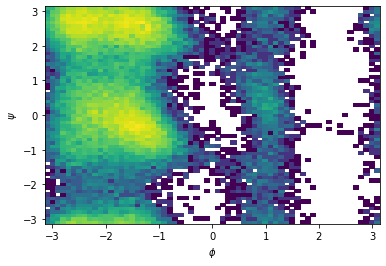

<IPython.core.display.Javascript object>

In [12]:
plot_2ala_ramachandran(traj)